In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
import random
from matplotlib import animation
from matplotlib.animation import FuncAnimation
%matplotlib inline
from scipy.optimize import curve_fit
import matplotlib.pylab as pylab
from scipy.stats import iqr
from scipy.spatial import Voronoi, voronoi_plot_2d, Delaunay
from collections import defaultdict
import itertools

In [16]:
def pb(x0,L):
    return((x0+L)%L)


class ant():

    def __init__(self,ids,flowc=0,stoppedc=0,cari=0):
        self.x=np.random.uniform(0,L)
        self.y=round(np.random.uniform(-1,1))*5        
        self.xunp=self.x
        self.v=np.random.uniform(0,1)
        self.dt=.05
        self.tau=.1
        #self.std=0
        self.v_pref=29#+min(np.random.normal(0,6.7),6.7)
        self.R=58
        self.r=4.5
        self.ids=ids
        self.stopped=0
        #print(cari)
        if (cari>=flowc):   
            #print(cari)
            self.v_pref=0  
            self.v=0
            self.stopped=1
            #self.x=500-cari*9.1
            #self.y=5*(cari-flowc-1)
                #print(stoppedc)
        self.ep=((self.v_pref)/self.tau)*(1-(self.r/self.R))**(-1.5)
        

  
    def step(self,x1=None,y1=None,vbar=0,counter=0):
        if (self.stopped==1):
            return
        fx=0
        fy=0
        x0=self.x
        y0=self.y
        r0=np.sqrt(x0**2+y0**2)
        r1=np.sqrt(x1**2+y1**2)
        fx=stepx(self.ep,self.R,x0,y0,x1,y1,L)        
        self.v=max(0,self.v+self.dt*((self.v_pref -self.v)/self.tau -fx))
        self.x=pb(self.x+self.dt*self.v,L)
        x0=self.x
        #r0=np.sqrt(x0**2+y0**2)
        #r1=np.sqrt(x1**2+y1*2)
        #dr=np.minimum(abs(r1-r0),L-abs(r1-r0))[0] #if any car is blocking, no lane change
        #if(dr<4.5):
        #    return #if any car is blocking, no lane change - return
        rand=np.random.uniform(-5,5)
        #rand=round(np.random.uniform(-1,1))*5 
        if(rand>0):#continuous lane change in +y
            w=np.where((np.minimum(abs(x1-x0),L-abs(x1-x0))<4.5) & (y1>y0))[0]  #y-blindsight
            y0=self.y+rand
            y0=min(y0,maxLy)
            if (len(w)>0):
                #print(rand)
                x11=x1[w]
                y11=y1[w]
                r0=np.sqrt(x0**2+y0*2)
                r11=np.sqrt(x11**2+y11**2)
                dr=min(np.minimum(np.sqrt((x11-x0)**2+(y11-y0)**2),np.sqrt((L-(x11-x0))**2+(y11-y0)**2)))  
                #if any car in the way of new change, no lane change
                if(dr<4.5):
                    return
            fx1=stepx(self.ep,self.R,x0,self.y,x1,y1,L) 
            fx2=stepx(self.ep,self.R,x0,y0,x1,y1,L)
            if (fx2<fx1): # accept lane change only if beneficial
                #print(rand)
                self.y=y0

        #print(rand)
        if(rand<0):#continuous lane change in +y
            w=np.where((np.minimum(abs(x1-x0),L-abs(x1-x0))<4.5) & (y1<y0))[0]
            y0=y0+rand
            y0=max(y0,minLy)
            #print(y0,self.y)
            #print(rand)
            if (len(w)>0):
                #print(rand)
                x12=x1[w]
                y12=y1[w]
                r0=np.sqrt(x0**2+y0*2)
                #r12=
                dr2=min(np.minimum(np.sqrt((x12-x0)**2+(y12-y0)**2),np.sqrt((L-(x12-x0))**2+(y12-y0)**2)))   
                
                if(dr2<4.5):
                    #print(rand)
                    return
            fx1=stepx(self.ep,self.R,x0,self.y,x1,y1,L) 
            fx2=stepx(self.ep,self.R,x0,y0,x1,y1,L)
            #print(fx2,fx1,self.x,self.y)
            #print(rand)
            #print(fx2,fx1)
            if (fx2<fx1):
                #print(rand)
                self.y=y0
        
def stepx(ep,R,x0,y0,x1,y1,L): #x direction force
    f=0
    r0=np.sqrt(x0**2+y0**2)
    r1=np.sqrt(x1**2+y1**2)
    #print(len(r1))
    w=np.where((y1<y0+4.5) & (y1>y0-4.5) & (x1!=x0))[0] # all cars in blindsight
    if (len(w)>0):
        #print(len(w))
        x01=x1[w]
        y01=y1[w]
        w=np.where((x01-x0>0) | (L+x01-x0<R))[0] # only cars in front (periodic bc)
        if (len(w)>0):
            #print(len(w))
            x01=x01[w]
            y01=y01[w]
            r01=np.sqrt(x01**2+y01*2)
            #dr=(np.minimum(abs(x01-x0),L-abs(x01-x0))) # minimum distance with only cars in front
            #print(len(dr))
            dr=min(np.minimum(np.sqrt((x01-x0)**2+(y01-y0)**2),np.sqrt((L-(x01-x0))**2+(y01-y0)**2)))   
            #print(dr)
            #dr=np.min(abs(r1-r0))
            if(dr<R):
                f=ep*(1-(dr/R))**(1.5)
    return(f)
        
        

class ants():
    def __init__(self,num_ants=20,flowc=0,stoppedc=0):
        self.members=[ant(ids=i,flowc=flowc,stoppedc=stoppedc,cari=i) for i in range(num_ants)];
        self.statex=np.array([bug.x for bug in self.members])
        self.stopped=np.array([bug.stopped for bug in self.members])
        self.statey=np.array([bug.y for bug in self.members])
        self.xunp=np.array([bug.xunp for bug in self.members])
        self.vel=np.array([bug.v for bug in self.members])
        self.ids=np.array([i for i in range(num_ants)])
        self.vp=np.array([bug.v_pref for bug in self.members])
        self.members=sorted(self.members, key=lambda y: y.x)
        self.counter=0
        self.vbar=0
    def step(self):
        #meanvel=0
        for i,bug in enumerate(self.members):
            #x1=pb(self.statex,L)           
            #y1=pb(self.statey,15)           
            bug.step(self.statex,self.statey,self.vbar,self.counter)
#		print(self.counter)
        self.members=sorted(self.members,key=lambda y: y.x)
        self.statex=np.array([bug.x for bug in self.members])
        self.statey=np.array([bug.y for bug in self.members])
        self.xunp=np.array([bug.xunp for bug in self.members])
        self.vel=np.array([bug.v for bug in self.members])
        self.ids=np.array([bug.ids for bug in self.members])
        self.stopped=np.array([bug.stopped for bug in self.members])
        return(np.mean(self.vel))
#		self.vp=np.array([bug.v_pref for bug in self.members])
    def view(self,t):
        fig=plt.figure()
        plt.plot(my_ants.statex,my_ants.statey,'ro',markersize=7)
        w=np.where(my_ants.stopped==1)[0]
        plt.plot(my_ants.statex[w],my_ants.statey[w],'ko',markersize=7)
        plt.xlim(0,1000)
        plt.ylim(-50,50)
        fig.savefig('./images/graph'+str(t)+'.png') #save figures
        plt.close(fig)



def run():
    a1=0
#posn=np.zeros((1,3))
#dens2=np.zeros(10000)
#phi2=np.zeros(10000)
    for t in range(10000):
        meanv=my_ants.step()
#	a1=np.c_[my_ants.ids,my_ants.ids*0+t,my_ants.xunp]
#	posn=(np.r_[posn,a1])
        if ((t>9998)):
            mv.append(meanv)
        #if ((t==10000-j)):

            my_ants.view(t)
#		w=np.where((my_ants.state>500) &(my_ants.state<1000))[0]
#		dens2[t]=len(w)/500*1000
#		phi2[t]=np.sum(my_ants.vel[w])*3.6/(500/1000)
        if t%1000==0:
            print(t)
#return (posn)


In [19]:
L=1000
maxLy=5
minLy=-5

rho_a=np.linspace(0.001,.16,10)*3
sc=np.array([1,5,10,20,30,50])
sc=sc*3
phi_a=np.zeros([len(rho_a),len(sc),11])
vel_a=np.zeros([len(rho_a),len(sc),11])
#vb2=np.zeros([15,10000])
for k,dens in enumerate(rho_a):
    #print(k)

    for j in range(len(phi_a[0,0,:])):
        for i,stopc in enumerate(sc):
            #print(i)
            mv=[]
            flowc=int(dens*L)
            #print(flowc)
            stoppedc=stopc
            num_ants=stoppedc+flowc    
            my_ants=ants(num_ants=num_ants,flowc=flowc,stoppedc=stoppedc)
#	posn=np.zeros(num_ants)
            run()
        #print(i,j)
            phi_a[k,i,j]=dens*mv[-1]
            vel_a[k,i,j]=mv[-1]
        print(j*k)
        #eval('rvp_cont_'+str(rho_a)+'fctot_100it')

0


/home/svivek/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:115: RuntimeWarning: invalid value encountered in sqrt
/home/svivek/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in sqrt
/home/svivek/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:84: RuntimeWarning: invalid value encountered in sqrt


1000
2000
3000
4000
5000
6000
7000
8000
9000
0


In [ ]:
sio.savemat("rvp_cont_vel_10it.mat",{'rvp_cont_vel_10it':vel_a})

In [10]:
#vel_sc=np.zeros(10)
#phi_sc=np.zeros(10)
#rho_ath=np.linspace(.001,.16,100)
#rho_a=np.linspace(.001,.16,10)

In [11]:
#for i in range(0,10):
#    vel=vel_a[i,0,0]*(sc+int(rho_a[i]*1000))/int(rho_a[i]*1000)
#    vel_sc[i]=np.mean(vel)
#    phi_sc[i]=np.mean(vel)*rho_a[i]     
#  

/home/svivek/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in power
  from ipykernel import kernelapp as app


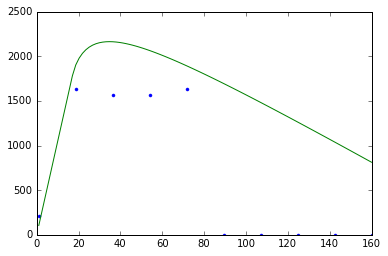

In [13]:
#plt.plot(rho_a*1000,phi_sc*3600,'.')
#lth,=plt.plot(rho_ath*1000,rho_ath*1000*29*3.6-np.nan_to_num(rho_ath*1000*(29*3.6)*(1-(4.5/(2*29)))**(-1.5)*(1-1/(2*rho_ath*1000*.029))**(1.5)),label='theory')
